# 📊 Sesión 3: Evaluación de Series de Tiempo
### Maestría en Analítica de Datos

**Requisitos previos:** Python, pandas, numpy, estadística básica

---

## 🗺️ Agenda

| Bloque | Tema |
|--------|------|
| 1 | Repaso: Componentes de una serie de tiempo | 
| 2 | Estacionariedad: concepto, pruebas y transformaciones |
| 3 | Autocorrelación: ACF y PACF |
| 4 | Train/Test split en series de tiempo | 
| 4.5 | Backtesting: Expanding Window, Rolling Window y multi-horizonte |
| 5 | Métricas de evaluación de pronósticos |
| 6 | Diagnóstico de residuos | 
| 7 | Ejercicio integrador | 
---

## ⚙️ Setup: Instalación e importación de librerías

In [1]:
# Instalar librerías necesarias (ejecutar solo una vez)
# !pip install statsmodels pandas numpy matplotlib seaborn scikit-learn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Estilo de gráficas
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['font.size'] = 11

np.random.seed(42)
print("✅ Librerías cargadas correctamente")

✅ Librerías cargadas correctamente


---
## 🛠️ Funciones utilitarias de la sesión

Ejecuta esta celda antes de empezar los bloques. Aquí se definen todas las funciones
reutilizables que se invocarán a lo largo del cuadernillo:
- `test_estacionariedad()` — pruebas ADF + KPSS
- `calcular_metricas()` — MAE, RMSE, MAPE, sMAPE, MASE
- `diagnostico_residuos()` — panel de diagnóstico visual + tests
- `backtesting_expanding()` — backtesting con ventana expandible
- `backtesting_rolling()` — backtesting con ventana fija


In [3]:
def test_estacionariedad(serie, nombre='Serie'):
    """
    Aplica ADF y KPSS y muestra resultados interpretados.
    """
    print(f"{'='*55}")
    print(f"  Pruebas de Estacionariedad: {nombre}")
    print(f"{'='*55}")
    
    # ADF
    adf_stat, adf_p, adf_lags, _, adf_cv, _ = adfuller(serie.dropna(), autolag='AIC')
    adf_result = "✅ Estacionaria" if adf_p < 0.05 else "❌ No estacionaria"
    print(f"\n📌 Test ADF")
    print(f"   Estadístico: {adf_stat:.4f}")
    print(f"   p-value:     {adf_p:.4f}")
    print(f"   Lags usados: {adf_lags}")
    print(f"   Resultado:   {adf_result} (H₀ rechazada = estacionaria)")
    
    # KPSS
    kpss_stat, kpss_p, kpss_lags, kpss_cv = kpss(serie.dropna(), regression='c', nlags='auto')
    kpss_result = "✅ Estacionaria" if kpss_p > 0.05 else "❌ No estacionaria"
    print(f"\n📌 Test KPSS")
    print(f"   Estadístico: {kpss_stat:.4f}")
    print(f"   p-value:     {kpss_p:.4f}  (aprox.)")
    print(f"   Lags usados: {kpss_lags}")
    print(f"   Resultado:   {kpss_result} (H₀ no rechazada = estacionaria)")
    print()


def calcular_metricas(y_real, y_pred, m=1, nombre='Modelo'):
    """
    Calcula MAE, RMSE, MAPE, sMAPE, MASE.
    
    Parámetros:
    -----------
    y_real : array-like - valores reales
    y_pred : array-like - valores pronosticados
    m      : int        - período estacional (para MASE)
    nombre : str        - nombre del modelo
    """
    y_real = np.array(y_real)
    y_pred = np.array(y_pred)
    errores = y_real - y_pred
    
    # MAE
    mae = np.mean(np.abs(errores))
    
    # RMSE
    rmse = np.sqrt(np.mean(errores ** 2))
    
    # MAPE (evita división por cero)
    mask = y_real != 0
    mape = np.mean(np.abs(errores[mask] / y_real[mask])) * 100
    
    # sMAPE
    smape = np.mean(200 * np.abs(errores) / (np.abs(y_real) + np.abs(y_pred))) 
    
    # MASE: comparar con naive estacional
    if len(y_real) > m:
        mae_naive = np.mean(np.abs(np.diff(y_real, n=m))) if m > 1 else np.mean(np.abs(np.diff(y_real)))
        mase = mae / mae_naive if mae_naive != 0 else np.nan
    else:
        mase = np.nan
    
    print(f"\n{'─'*40}")
    print(f"  📊 {nombre}")
    print(f"{'─'*40}")
    print(f"  MAE   : {mae:>10.2f}")
    print(f"  RMSE  : {rmse:>10.2f}")
    print(f"  MAPE  : {mape:>9.2f}%")
    print(f"  sMAPE : {smape:>9.2f}%")
    print(f"  MASE  : {mase:>10.4f}  {'✅ mejor que naive' if mase < 1 else '❌ peor que naive' if not np.isnan(mase) else ''}")
    
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'sMAPE': smape, 'MASE': mase}


def diagnostico_residuos(residuos, nombre='Modelo', lags=20):
    """
    Panel de diagnóstico completo de residuos.
    """
    from scipy import stats
    
    residuos = pd.Series(residuos).dropna()
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    fig.suptitle(f'Diagnóstico de Residuos — {nombre}', fontsize=13, fontweight='bold')
    
    # 1. Residuos en el tiempo
    axes[0, 0].plot(residuos.values, color='steelblue', linewidth=1)
    axes[0, 0].axhline(0, color='red', linestyle='--')
    axes[0, 0].fill_between(range(len(residuos)), residuos.values, 0, alpha=0.3, color='steelblue')
    axes[0, 0].set_title('Residuos en el tiempo')
    axes[0, 0].set_xlabel('Período')
    
    # 2. Histograma
    axes[0, 1].hist(residuos, bins=20, edgecolor='white', color='steelblue', density=True)
    xmin, xmax = axes[0, 1].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    axes[0, 1].plot(x, stats.norm.pdf(x, residuos.mean(), residuos.std()), 'r--', linewidth=2, label='Normal teórica')
    axes[0, 1].set_title('Distribución de residuos')
    axes[0, 1].legend()
    
    # 3. ACF de residuos
    plot_acf(residuos, lags=lags, ax=axes[1, 0], title='ACF de residuos', color='steelblue')
    
    # 4. Q-Q plot
    stats.probplot(residuos, dist='norm', plot=axes[1, 1])
    axes[1, 1].set_title('Q-Q Plot (normalidad)')
    
    plt.tight_layout()
    plt.show()
    
    # Tests estadísticos
    lb_result = acorr_ljungbox(residuos, lags=lags, return_df=True)
    _, norm_p  = stats.shapiro(residuos[:50])  # Shapiro funciona mejor con n<50
    
    print(f"\n📋 Resumen estadístico de residuos ({nombre}):")
    print(f"   Media:             {residuos.mean():>10.4f}  {'✅' if abs(residuos.mean()) < residuos.std()*0.1 else '⚠️'}")
    print(f"   Desv. estándar:    {residuos.std():>10.4f}")
    print(f"   Skewness:          {residuos.skew():>10.4f}  {'✅' if abs(residuos.skew()) < 0.5 else '⚠️ asimetría'  }")
    print(f"   Kurtosis:          {residuos.kurtosis():>10.4f}  {'✅' if abs(residuos.kurtosis()) < 1 else '⚠️ colas pesadas'}")
    
    # Ljung-Box para autocorrelación
    lb_sig = (lb_result['lb_pvalue'] < 0.05).any()
    print(f"\n   Ljung-Box (lags 1-{lags}):  {'⚠️ Autocorrelación detectada' if lb_sig else '✅ Sin autocorrelación significativa'}")
    print(f"   Shapiro-Wilk:      p={norm_p:.4f}  {'✅ Normalidad OK' if norm_p > 0.05 else '⚠️ No normal'}")


def backtesting_expanding(serie, init_train, horizonte=1, verbose=True):
    """
    Backtesting con Expanding Window.
    
    Simula el proceso de re-entrenamiento paso a paso:
    - Entrena con [0 : init_train + fold]
    - Predice el siguiente período (o los siguientes `horizonte` períodos)
    - Agrega el período real y repite
    
    Parámetros:
    -----------
    serie      : pd.Series con índice temporal
    init_train : int, número de observaciones iniciales para entrenar
    horizonte  : int, cuántos pasos adelante pronosticar en cada fold
    """
    n = len(serie)
    predicciones = []
    reales       = []
    fechas       = []
    fold_info    = []

    for fold, corte in enumerate(range(init_train, n - horizonte + 1)):
        train_fold = serie.iloc[:corte]
        val_fold   = serie.iloc[corte: corte + horizonte]
        
        # ── MODELO: Naive estacional (lag=12) ──
        # En sesiones futuras, aquí irá ARIMA, ETS, etc.
        lag = 12
        if len(train_fold) >= lag:
            pred = train_fold.iloc[-lag: -lag + horizonte].values
            if len(pred) < horizonte:
                pred = np.tile(train_fold.iloc[-lag:].values, int(np.ceil(horizonte/lag)))[:horizonte]
        else:
            pred = np.full(horizonte, train_fold.iloc[-1])
        
        predicciones.extend(pred)
        reales.extend(val_fold.values)
        fechas.extend(val_fold.index)
        fold_info.append({'fold': fold+1, 'train_size': corte, 'val_start': val_fold.index[0]})
        
        if verbose and fold < 3:
            print(f"Fold {fold+1:>2} | Train: {corte:>3} obs ({train_fold.index[0].strftime('%Y-%m')}→{train_fold.index[-1].strftime('%Y-%m')}) "
                  f"| Val: {val_fold.index[0].strftime('%Y-%m')} | Pred: {pred[0]:.1f} | Real: {val_fold.values[0]:.1f}")
    
    if verbose:
        print(f"   ... ({fold + 1} folds totales)")
    
    return pd.Series(predicciones, index=fechas), pd.Series(reales, index=fechas)


def backtesting_rolling(serie, window_size, horizonte=1, verbose=True):
    """
    Backtesting con Rolling Window (ventana fija).
    
    - Entrena con [fold : fold + window_size]
    - Predice horizonte pasos adelante
    - Desplaza la ventana un período y repite
    """
    n = len(serie)
    predicciones = []
    reales       = []
    fechas       = []

    for fold, inicio in enumerate(range(0, n - window_size - horizonte + 1)):
        train_fold = serie.iloc[inicio: inicio + window_size]
        val_fold   = serie.iloc[inicio + window_size: inicio + window_size + horizonte]
        
        if len(val_fold) < horizonte:
            break
        
        # ── MODELO: Naive estacional (lag=12) ──
        lag = 12
        if len(train_fold) >= lag:
            pred = train_fold.iloc[-lag: -lag + horizonte].values
            if len(pred) < horizonte:
                pred = np.tile(train_fold.iloc[-lag:].values, int(np.ceil(horizonte/lag)))[:horizonte]
        else:
            pred = np.full(horizonte, train_fold.iloc[-1])
        
        predicciones.extend(pred)
        reales.extend(val_fold.values)
        fechas.extend(val_fold.index)
        
        if verbose and fold < 3:
            print(f"Fold {fold+1:>2} | Ventana: [{train_fold.index[0].strftime('%Y-%m')}→{train_fold.index[-1].strftime('%Y-%m')}] "
                  f"| Val: {val_fold.index[0].strftime('%Y-%m')} | Pred: {pred[0]:.1f} | Real: {val_fold.values[0]:.1f}")

    if verbose:
        print(f"   ... ({fold + 1} folds totales)")
    
    return pd.Series(predicciones, index=fechas), pd.Series(reales, index=fechas)


print('✅ Todas las funciones utilitarias cargadas')

✅ Todas las funciones utilitarias cargadas


---
## 📦 Datos de la sesión

Trabajaremos con **dos datasets** a lo largo de la sesión:

1. **`airline`**: Pasajeros mensuales de aerolínea (1949–1960) — clásico con tendencia y estacionalidad multiplicativa.
2. **`retail`**: Ventas semanales simuladas de retail — útil para ejercicios de diagnóstico.

In [4]:
# Dataset 1: Pasajeros de aerolínea (clásico)
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
airline = pd.read_csv(url, parse_dates=['Month'], index_col='Month')
airline.columns = ['Pasajeros']
airline.index.freq = 'MS'  # frecuencia mensual

# Dataset 2: Ventas simuladas de retail
n = 200
tiempo = pd.date_range('2020-01-01', periods=n, freq='W')
tendencia = np.linspace(500, 900, n)
estacionalidad = 80 * np.sin(2 * np.pi * np.arange(n) / 52)
ruido = np.random.normal(0, 40, n)
retail = pd.DataFrame({'Ventas': tendencia + estacionalidad + ruido}, index=tiempo)

print("✅ Datos cargados")
print(f"Airline: {airline.shape[0]} observaciones ({airline.index[0].strftime('%Y-%m')} — {airline.index[-1].strftime('%Y-%m')})")
print(f"Retail:  {retail.shape[0]} observaciones ({retail.index[0].strftime('%Y-%m-%d')} — {retail.index[-1].strftime('%Y-%m-%d')})")

✅ Datos cargados
Airline: 144 observaciones (1949-01 — 1960-12)
Retail:  200 observaciones (2020-01-05 — 2023-10-29)


---
# Repaso: Componentes de una Serie de Tiempo

---

### Concepto clave

Toda serie de tiempo puede descomponerse en:

$$Y_t = T_t + S_t + R_t \quad \text{(aditiva)}$$
$$Y_t = T_t \times S_t \times R_t \quad \text{(multiplicativa)}$$

| Componente | Descripción | Ejemplo |
|------------|-------------|----------|
| **Tendencia** ($T_t$) | Dirección a largo plazo | Crecimiento de ventas anual |
| **Estacionalidad** ($S_t$) | Patrones periódicos fijos | Más ventas en diciembre |
| **Ciclo** ($C_t$) | Fluctuaciones de largo plazo | Ciclos económicos |
| **Residuo** ($R_t$) | Lo que no explican los demás | Ruido, eventos atípicos |

> **¿Cuándo usar aditivo vs multiplicativo?**  
> Si la **amplitud de la estacionalidad crece** junto con el nivel de la serie → **multiplicativo**.  
> Si la amplitud es **constante** → **aditivo**.

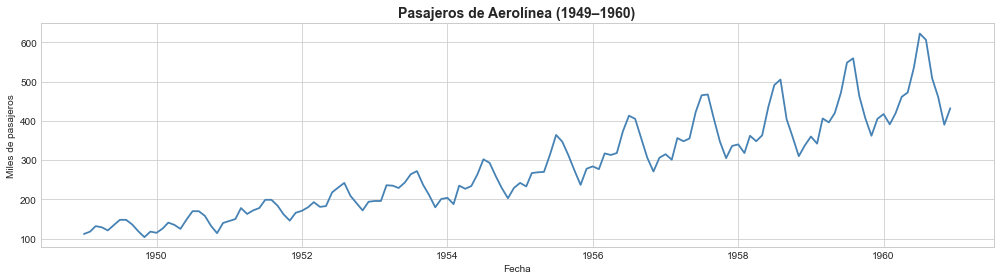

💬 Pregunta para reflexionar: ¿Qué componentes puede identificar visualmente?


In [5]:
# Visualización inicial de la serie airline
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(airline.index, airline['Pasajeros'], color='steelblue', linewidth=1.8)
ax.set_title('Pasajeros de Aerolínea (1949–1960)', fontsize=14, fontweight='bold')
ax.set_ylabel('Miles de pasajeros')
ax.set_xlabel('Fecha')
plt.tight_layout()
plt.show()

print("💬 Pregunta para reflexionar: ¿Qué componentes puede identificar visualmente?")

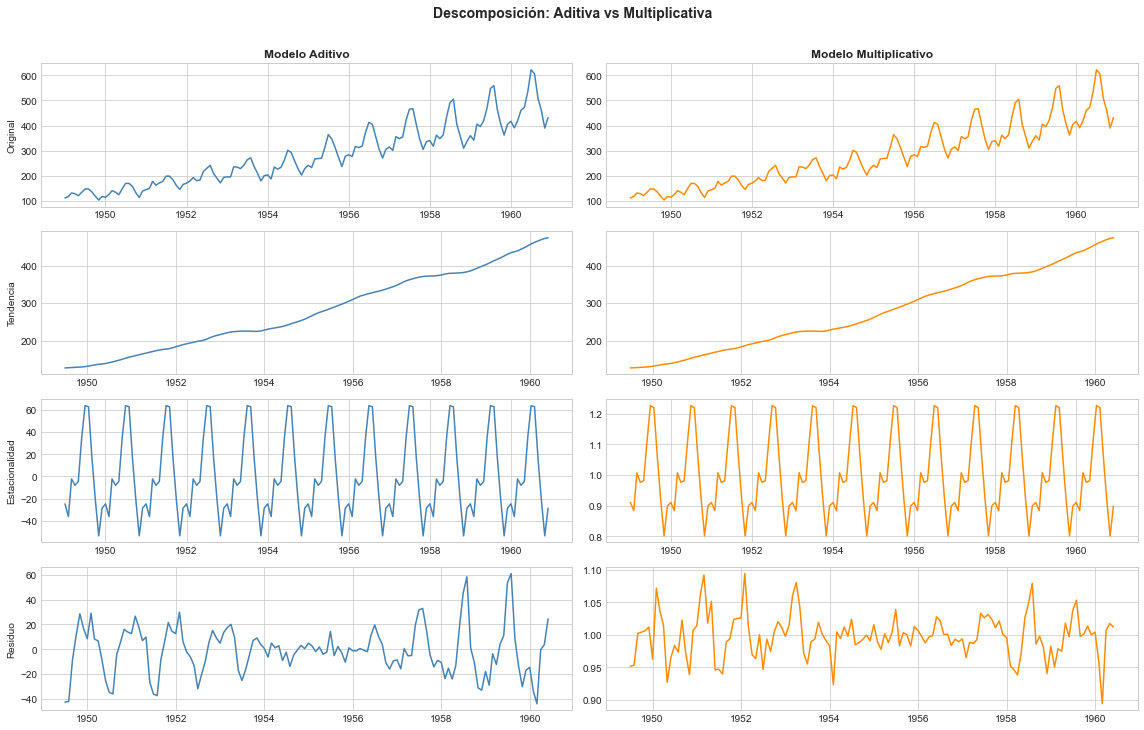


💬 Observen los residuos: ¿Cuál modelo deja residuos más 'aleatorios' y centrados en cero/uno?


In [6]:
# Descomposición clásica
# Modelo multiplicativo (porque la estacionalidad crece con la tendencia)
decomp_mult = seasonal_decompose(airline['Pasajeros'], model='multiplicative', period=12)
decomp_add  = seasonal_decompose(airline['Pasajeros'], model='additive', period=12)

fig, axes = plt.subplots(4, 2, figsize=(16, 10))
fig.suptitle('Descomposición: Aditiva vs Multiplicativa', fontsize=14, fontweight='bold', y=1.01)

labels = ['Original', 'Tendencia', 'Estacionalidad', 'Residuo']
add_series = [airline['Pasajeros'], decomp_add.trend, decomp_add.seasonal, decomp_add.resid]
mult_series = [airline['Pasajeros'], decomp_mult.trend, decomp_mult.seasonal, decomp_mult.resid]

for i, (label, s_a, s_m) in enumerate(zip(labels, add_series, mult_series)):
    axes[i, 0].plot(s_a, color='steelblue')
    axes[i, 0].set_ylabel(label)
    if i == 0: axes[i, 0].set_title('Modelo Aditivo', fontweight='bold')
    
    axes[i, 1].plot(s_m, color='darkorange')
    if i == 0: axes[i, 1].set_title('Modelo Multiplicativo', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💬 Observen los residuos: ¿Cuál modelo deja residuos más 'aleatorios' y centrados en cero/uno?")

### 📝 

- La descomposición nos da una **primera radiografía** de la serie.
- Los residuos del modelo correcto deben parecer **ruido blanco** (sin estructura).
- Comparar aditivo vs multiplicativo observando los **residuos** es una buena práctica.

---

---
# Estacionariedad

---

### ¿Qué es la estacionariedad?

Una serie es **estacionaria** si sus propiedades estadísticas no cambian con el tiempo:

| Propiedad | Condición |
|-----------|----------|
| Media | $E[Y_t] = \mu$ (constante) |
| Varianza | $Var[Y_t] = \sigma^2$ (constante) |
| Autocovarianza | Depende solo del **lag**, no del tiempo |

> ⚠️ **¿Por qué importa?** La mayoría de los modelos clásicos (ARIMA, regresión) asumen estacionariedad. Ignorarla produce modelos espurios.

### Tipos de no-estacionariedad

1. **Tendencia determinística** → se elimina con regresión o diferenciación
2. **Tendencia estocástica (raíz unitaria)** → se elimina con diferenciación
3. **Varianza no constante (heterocedasticidad)** → se elimina con transformación logarítmica

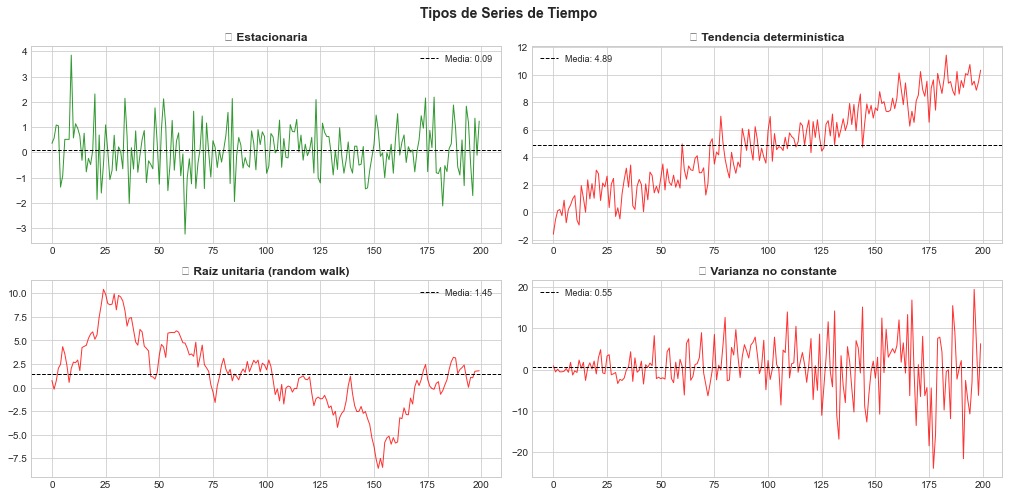

In [7]:
# Ejemplo visual: series estacionaria vs no-estacionaria
n = 200
t = np.arange(n)

serie_estacionaria     = np.random.normal(0, 1, n)
serie_tendencia        = 0.05 * t + np.random.normal(0, 1, n)
serie_raiz_unitaria    = np.cumsum(np.random.normal(0, 1, n))  # random walk
serie_heterocedástica  = np.random.normal(0, 1 + 0.05 * t, n)

fig, axes = plt.subplots(2, 2, figsize=(14, 7))
fig.suptitle('Tipos de Series de Tiempo', fontsize=14, fontweight='bold')

series = [serie_estacionaria, serie_tendencia, serie_raiz_unitaria, serie_heterocedástica]
titulos = ['✅ Estacionaria', '❌ Tendencia determinística', '❌ Raíz unitaria (random walk)', '❌ Varianza no constante']
colores = ['green', 'red', 'red', 'red']

for ax, s, titulo, c in zip(axes.flatten(), series, titulos, colores):
    ax.plot(s, color=c, alpha=0.8, linewidth=1)
    ax.set_title(titulo, fontweight='bold')
    ax.axhline(y=np.mean(s), color='black', linestyle='--', linewidth=1, label=f'Media: {np.mean(s):.2f}')
    ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

### 🧪 Pruebas de Estacionariedad

#### Test ADF (Augmented Dickey-Fuller)
- **H₀:** La serie tiene raíz unitaria (NO estacionaria)
- **H₁:** La serie es estacionaria
- **Rechazamos H₀** si p-value < 0.05 → **serie estacionaria**

#### Test KPSS (Kwiatkowski–Phillips–Schmidt–Shin)
- **H₀:** La serie ES estacionaria
- **H₁:** La serie tiene raíz unitaria (NO estacionaria)
- **Rechazamos H₀** si p-value < 0.05 → **serie NO estacionaria**

> 💡 **Usar ambas pruebas juntas** es más robusto. Si ambas concuerdan, más confianza.

| ADF | KPSS | Conclusión |
|-----|------|------------|
| p < 0.05 | p > 0.05 | ✅ Estacionaria |
| p > 0.05 | p < 0.05 | ❌ No estacionaria |
| p < 0.05 | p < 0.05 | ⚠️ Estacionaria en tendencia |
| p > 0.05 | p > 0.05 | ⚠️ Resultados ambiguos |

In [8]:
# Probemos con la serie airline
test_estacionariedad(airline['Pasajeros'], 'Airline - Serie original')

  Pruebas de Estacionariedad: Airline - Serie original

📌 Test ADF
   Estadístico: 0.8154
   p-value:     0.9919
   Lags usados: 13
   Resultado:   ❌ No estacionaria (H₀ rechazada = estacionaria)

📌 Test KPSS
   Estadístico: 1.6513
   p-value:     0.0100  (aprox.)
   Lags usados: 8
   Resultado:   ❌ No estacionaria (H₀ no rechazada = estacionaria)



### 🔧 Transformaciones para lograr estacionariedad

#### 1. Diferenciación
$$\Delta Y_t = Y_t - Y_{t-1}$$

#### 2. Transformación logarítmica (estabiliza varianza)
$$\ln(Y_t)$$

#### 3. Diferenciación estacional
$$\Delta_m Y_t = Y_t - Y_{t-m}$$

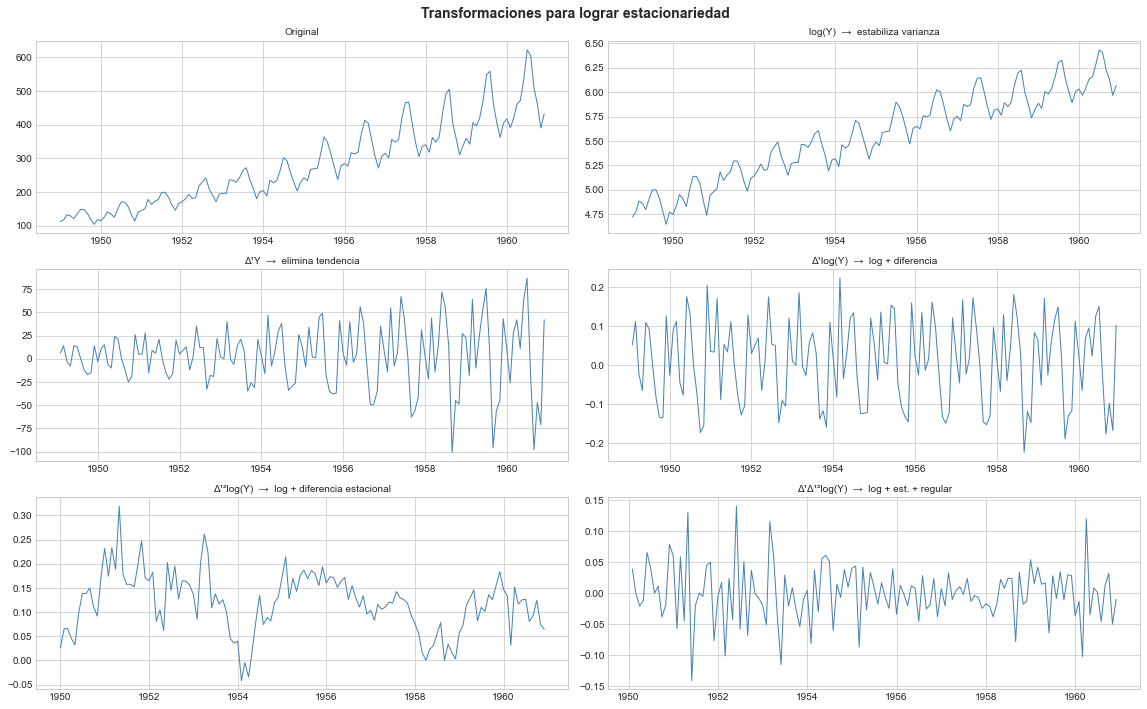

In [9]:
# Transformaciones sobre la serie airline
log_serie   = np.log(airline['Pasajeros'])
diff1       = airline['Pasajeros'].diff()
log_diff1   = log_serie.diff()
log_diff_s  = log_serie.diff(12)      # diferencia estacional
log_diff_ds = log_serie.diff(12).diff()  # log + estacional + regular

fig, axes = plt.subplots(3, 2, figsize=(16, 10))
fig.suptitle('Transformaciones para lograr estacionariedad', fontsize=14, fontweight='bold')

pares = [
    (airline['Pasajeros'],  'Original'),
    (log_serie,             'log(Y)  →  estabiliza varianza'),
    (diff1,                 'Δ¹Y  →  elimina tendencia'),
    (log_diff1,             'Δ¹log(Y)  →  log + diferencia'),
    (log_diff_s,            'Δ¹²log(Y)  →  log + diferencia estacional'),
    (log_diff_ds,           'Δ¹Δ¹²log(Y)  →  log + est. + regular'),
]

for ax, (s, titulo) in zip(axes.flatten(), pares):
    ax.plot(s.dropna(), linewidth=1, color='steelblue')
    ax.set_title(titulo, fontsize=10)

plt.tight_layout()
plt.show()

In [10]:
# Verificamos la transformación final
test_estacionariedad(log_diff_ds.dropna(), 'Airline - log + Δ¹² + Δ¹ (transformada)')

  Pruebas de Estacionariedad: Airline - log + Δ¹² + Δ¹ (transformada)

📌 Test ADF
   Estadístico: -4.4433
   p-value:     0.0002
   Lags usados: 12
   Resultado:   ✅ Estacionaria (H₀ rechazada = estacionaria)

📌 Test KPSS
   Estadístico: 0.0732
   p-value:     0.1000  (aprox.)
   Lags usados: 3
   Resultado:   ✅ Estacionaria (H₀ no rechazada = estacionaria)



---
# Autocorrelación: ACF y PACF

---

### Autocorrelación (ACF)

Mide la correlación de $Y_t$ con $Y_{t-k}$ (su versión rezagada $k$ períodos):

$$\rho_k = \frac{Cov(Y_t, Y_{t-k})}{Var(Y_t)}$$

### Autocorrelación Parcial (PACF)

Mide la correlación entre $Y_t$ y $Y_{t-k}$ **eliminando el efecto de los rezagos intermedios**.

### ¿Para qué sirven?

| Gráfico | Propósito principal |
|---------|---------------------|
| ACF | Detectar estacionalidad, evaluar residuos, identificar orden MA |
| PACF | Identificar orden AR |

Las **bandas de confianza** al 95% son $\pm 1.96 / \sqrt{n}$. Barras fuera = autocorrelación significativa.

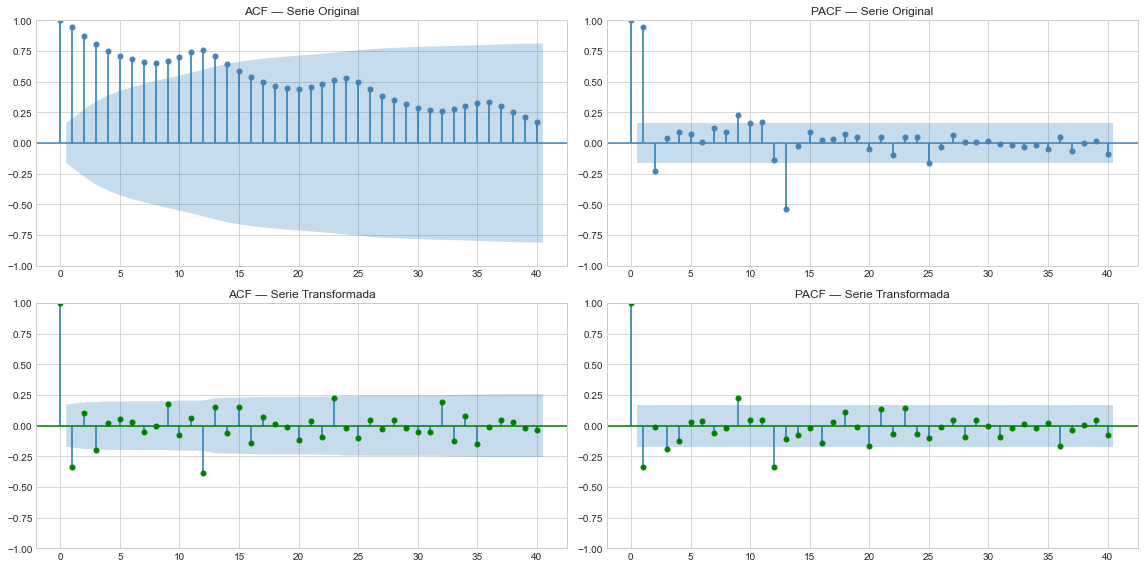


💬 Puntos de discusión:
   • Serie original: ACF con caída muy lenta → indicio fuerte de no estacionariedad
   • Serie original: Picos en lags 12, 24 → estacionalidad anual clara
   • Serie transformada: ¿Qué estructura queda? ¿Cuántos lags son significativos?



In [11]:
# ACF y PACF de la serie original vs transformada
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

plot_acf(airline['Pasajeros'],          lags=40, ax=axes[0, 0], title='ACF — Serie Original',       color='steelblue')
plot_pacf(airline['Pasajeros'],         lags=40, ax=axes[0, 1], title='PACF — Serie Original',      color='steelblue')
plot_acf(log_diff_ds.dropna(),          lags=40, ax=axes[1, 0], title='ACF — Serie Transformada',   color='green')
plot_pacf(log_diff_ds.dropna(),         lags=40, ax=axes[1, 1], title='PACF — Serie Transformada',  color='green')

plt.tight_layout()
plt.show()

print("""
💬 Puntos de discusión:
   • Serie original: ACF con caída muy lenta → indicio fuerte de no estacionariedad
   • Serie original: Picos en lags 12, 24 → estacionalidad anual clara
   • Serie transformada: ¿Qué estructura queda? ¿Cuántos lags son significativos?
""")

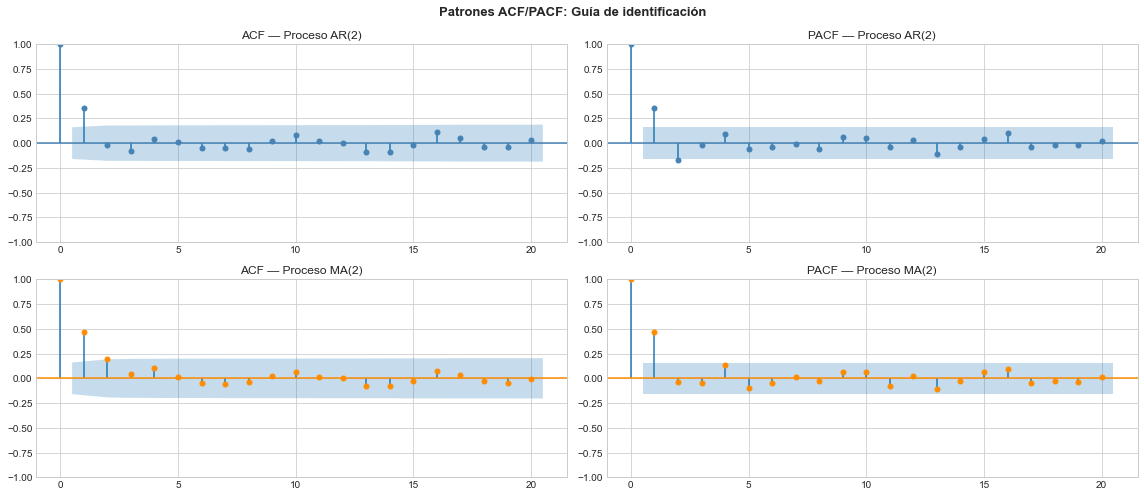


📌 Regla de identificación (válida para modelos puros):
   AR(p)  →  ACF: caída gradual (exponencial/sinusoidal)   |  PACF: corte abrupto después del lag p
   MA(q)  →  ACF: corte abrupto después del lag q           |  PACF: caída gradual
   ARMA   →  Ambas con caída gradual → usar AIC/BIC para elegir orden



In [12]:
# Cómo leer los gráficos ACF/PACF para identificar modelos
# Patrones típicos:

n = 150
errores = np.random.normal(0, 1, n)

# AR(2): Y_t = 0.6*Y_{t-1} - 0.3*Y_{t-2} + e_t
ar2 = np.zeros(n)
for t in range(2, n):
    ar2[t] = 0.6 * ar2[t-1] - 0.3 * ar2[t-2] + errores[t]

# MA(2): Y_t = e_t + 0.7*e_{t-1} + 0.3*e_{t-2}
ma2 = np.zeros(n)
for t in range(2, n):
    ma2[t] = errores[t] + 0.7 * errores[t-1] + 0.3 * errores[t-2]

fig, axes = plt.subplots(2, 2, figsize=(16, 7))
fig.suptitle('Patrones ACF/PACF: Guía de identificación', fontsize=13, fontweight='bold')

plot_acf(ar2,  lags=20, ax=axes[0, 0], title='ACF — Proceso AR(2)',  color='steelblue')
plot_pacf(ar2, lags=20, ax=axes[0, 1], title='PACF — Proceso AR(2)', color='steelblue')
plot_acf(ma2,  lags=20, ax=axes[1, 0], title='ACF — Proceso MA(2)',  color='darkorange')
plot_pacf(ma2, lags=20, ax=axes[1, 1], title='PACF — Proceso MA(2)', color='darkorange')

plt.tight_layout()
plt.show()

print("""
📌 Regla de identificación (válida para modelos puros):
   AR(p)  →  ACF: caída gradual (exponencial/sinusoidal)   |  PACF: corte abrupto después del lag p
   MA(q)  →  ACF: corte abrupto después del lag q           |  PACF: caída gradual
   ARMA   →  Ambas con caída gradual → usar AIC/BIC para elegir orden
""")

---
# Train/Test Split en Series de Tiempo

---

### ⚠️ El error más común: usar train/test aleatorio

En series de tiempo **el tiempo importa**. Mezclar datos futuros en el entrenamiento es **data leakage** (contaminación temporal).

```
❌ INCORRECTO:  train_test_split(X, y, test_size=0.2, shuffle=True)
✅ CORRECTO:    Cortar cronológicamente
```

### Estrategias de validación

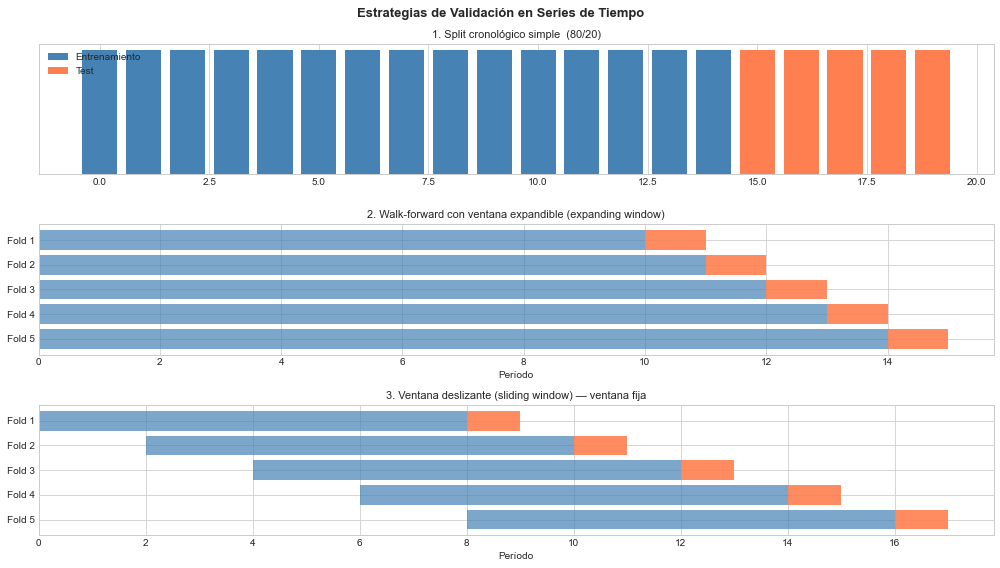


📌 ¿Cuándo usar cada una?
   Split simple       →  baseline rápido, OK si proceso es estable
   Walk-forward       →  cuando queremos estimar desempeño real en producción
   Sliding window     →  cuando el proceso cambia con el tiempo (no útil info antigua)



In [13]:
# Visualización de las 3 estrategias de validación
fig, axes = plt.subplots(3, 1, figsize=(14, 8))
fig.suptitle('Estrategias de Validación en Series de Tiempo', fontsize=13, fontweight='bold')

n = 20
x = np.arange(n)

# 1. Split simple
corte = 15
axes[0].bar(x[:corte], [1]*corte, color='steelblue', label='Entrenamiento')
axes[0].bar(x[corte:], [1]*(n-corte), color='coral', label='Test')
axes[0].set_title('1. Split cronológico simple  (80/20)', fontsize=11)
axes[0].set_yticks([])
axes[0].legend(loc='upper left')

# 2. Walk-forward (expanding window)
axes[1].set_title('2. Walk-forward con ventana expandible (expanding window)', fontsize=11)
for i, (train_end, test_point) in enumerate([(10,11),(11,12),(12,13),(13,14),(14,15)]):
    y_pos = 5 - i
    axes[1].barh(y_pos, train_end, color='steelblue', alpha=0.7)
    axes[1].barh(y_pos, 1, left=train_end, color='coral', alpha=0.9)
axes[1].set_yticks(range(1, 6))
axes[1].set_yticklabels([f'Fold {i}' for i in range(5, 0, -1)])
axes[1].set_xlabel('Período')

# 3. Sliding window
axes[2].set_title('3. Ventana deslizante (sliding window) — ventana fija', fontsize=11)
window = 8
for i, start in enumerate([0, 2, 4, 6, 8]):
    y_pos = 5 - i
    axes[2].barh(y_pos, window, left=start, color='steelblue', alpha=0.7)
    axes[2].barh(y_pos, 1, left=start+window, color='coral', alpha=0.9)
axes[2].set_yticks(range(1, 6))
axes[2].set_yticklabels([f'Fold {i}' for i in range(5, 0, -1)])
axes[2].set_xlabel('Período')

plt.tight_layout()
plt.show()

print("""
📌 ¿Cuándo usar cada una?
   Split simple       →  baseline rápido, OK si proceso es estable
   Walk-forward       →  cuando queremos estimar desempeño real en producción
   Sliding window     →  cuando el proceso cambia con el tiempo (no útil info antigua)
""")

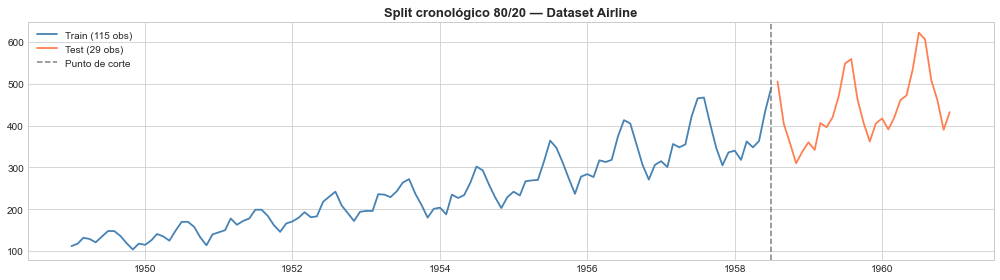

Train: 1949-01 → 1958-07  (115 obs)
Test:  1958-08 → 1960-12   (29 obs)


In [14]:
# Implementación práctica del split en nuestra serie airline
train_size = int(len(airline) * 0.8)
train = airline.iloc[:train_size]
test  = airline.iloc[train_size:]

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(train.index, train['Pasajeros'], color='steelblue', label=f'Train ({len(train)} obs)', linewidth=1.8)
ax.plot(test.index,  test['Pasajeros'],  color='coral',     label=f'Test ({len(test)} obs)',  linewidth=1.8)
ax.axvline(x=train.index[-1], color='gray', linestyle='--', linewidth=1.5, label='Punto de corte')
ax.set_title('Split cronológico 80/20 — Dataset Airline', fontsize=13, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

print(f"Train: {train.index[0].strftime('%Y-%m')} → {train.index[-1].strftime('%Y-%m')}  ({len(train)} obs)")
print(f"Test:  {test.index[0].strftime('%Y-%m')} → {test.index[-1].strftime('%Y-%m')}   ({len(test)} obs)")

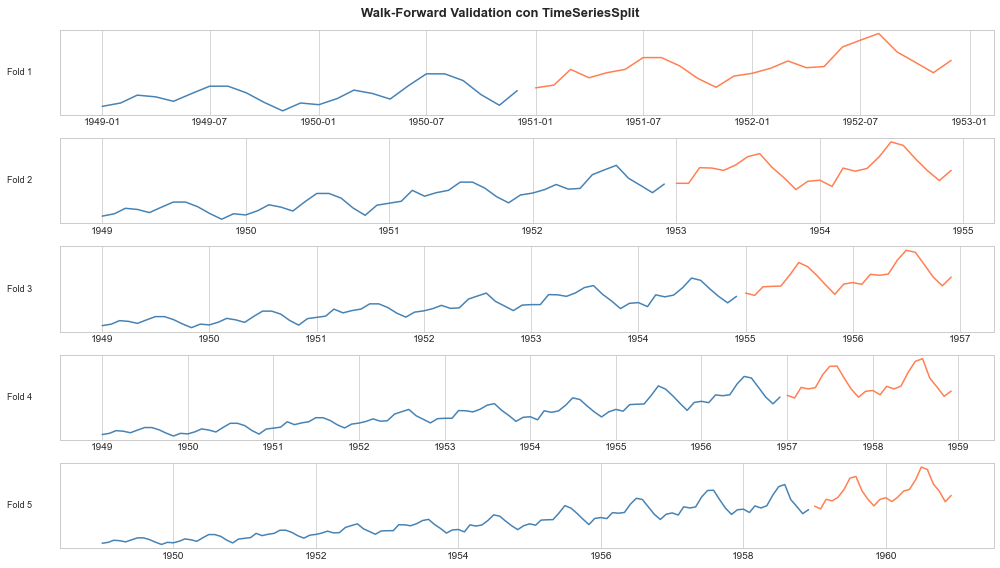

In [15]:
# Walk-Forward con TimeSeriesSplit de sklearn
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5, gap=0)

fig, axes = plt.subplots(5, 1, figsize=(14, 8))
fig.suptitle('Walk-Forward Validation con TimeSeriesSplit', fontsize=13, fontweight='bold')

for fold, (train_idx, val_idx) in enumerate(tscv.split(airline)):
    ax = axes[fold]
    ax.plot(airline.index[train_idx], airline.iloc[train_idx]['Pasajeros'], color='steelblue', linewidth=1.5)
    ax.plot(airline.index[val_idx],   airline.iloc[val_idx]['Pasajeros'],   color='coral',     linewidth=1.5)
    ax.set_ylabel(f'Fold {fold+1}', rotation=0, labelpad=40, va='center', fontsize=9)
    ax.set_yticks([])

plt.tight_layout()
plt.show()

---
#  Backtesting: Expanding Window y Rolling Window

---

### ¿Qué es el Backtesting en series de tiempo?

**Backtesting** es el proceso de evaluar un modelo simulando cómo habría funcionado en el pasado: entrenamos con datos históricos y validamos en períodos subsiguientes, respetando siempre el orden temporal.

> 💡 La idea central: **simular el proceso real de producción**. Cada vez que el modelo se re-entrena, solo ve datos que en ese momento ya existían.

---

### Las dos estrategias principales

#### 1. Expanding Window (ventana expandible)
- El conjunto de entrenamiento **crece** con cada fold.
- El modelo siempre usa **toda** la historia disponible.
- **Ventaja:** más datos → modelos potencialmente más estables.
- **Ideal cuando:** el proceso es estacionario y la historia completa es relevante.

```
Fold 1: [=====Train=====] [Val]
Fold 2: [========Train========] [Val]
Fold 3: [===========Train===========] [Val]
```

#### 2. Rolling Window (ventana deslizante / fija)
- El conjunto de entrenamiento tiene **tamaño fijo**: entra un período nuevo, sale el más antiguo.
- **Ventaja:** más relevante si el proceso cambia con el tiempo (no-estacionario, concept drift).
- **Ideal cuando:** datos recientes son más informativos que los antiguos.

```
Fold 1: [=====Train=====] [Val]
Fold 2:   [=====Train=====] [Val]
Fold 3:     [=====Train=====] [Val]
```

#### ¿Cuándo usar cuál?

| Situación | Estrategia recomendada |
|-----------|------------------------|
| Proceso estable, historia larga relevante | Expanding window |
| Proceso cambiante (e.g. post-pandemia) | Rolling window |
| Poca datos disponibles | Expanding window |
| Detectar concept drift | Rolling window |
| Producción con re-entrenamiento periódico | Rolling window |

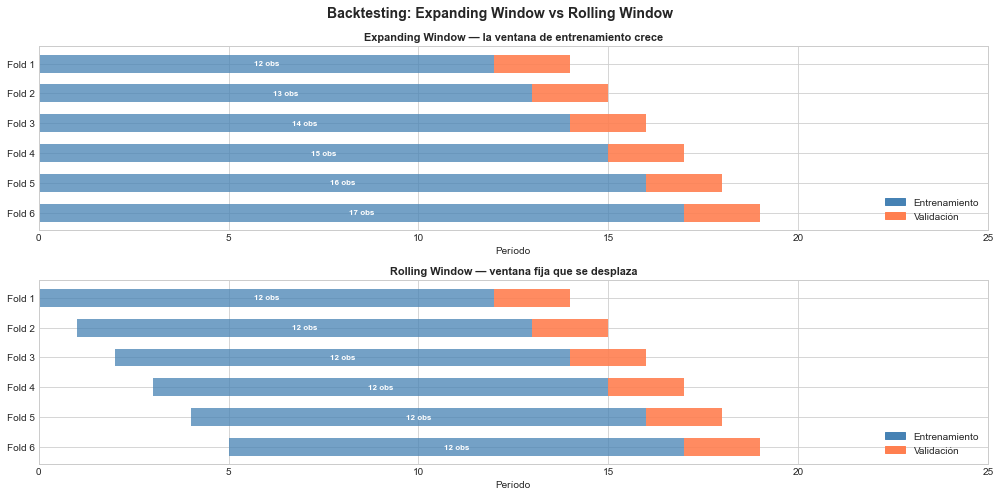

In [16]:
# Visualización comparativa: Expanding vs Rolling
fig, axes = plt.subplots(2, 1, figsize=(14, 7))
fig.suptitle('Backtesting: Expanding Window vs Rolling Window', fontsize=14, fontweight='bold')

n_total = 24
n_folds = 6
init_train = 12
window_size = 12
h = 2  # horizonte de validación

# --- Expanding Window ---
ax = axes[0]
ax.set_title('Expanding Window — la ventana de entrenamiento crece', fontsize=11, fontweight='bold')
for fold in range(n_folds):
    train_end = init_train + fold
    val_end   = min(train_end + h, n_total)
    y = n_folds - fold
    ax.barh(y, train_end, color='steelblue', alpha=0.75, height=0.6)
    ax.barh(y, val_end - train_end, left=train_end, color='coral', alpha=0.9, height=0.6)
    ax.text(train_end / 2, y, f'{train_end} obs', va='center', ha='center', fontsize=8, color='white', fontweight='bold')

ax.set_yticks(range(1, n_folds + 1))
ax.set_yticklabels([f'Fold {i}' for i in range(n_folds, 0, -1)])
ax.set_xlabel('Período')
ax.set_xlim(0, n_total + 1)
from matplotlib.patches import Patch
ax.legend(handles=[Patch(color='steelblue', label='Entrenamiento'), Patch(color='coral', label='Validación')],
          loc='lower right')

# --- Rolling Window ---
ax = axes[1]
ax.set_title('Rolling Window — ventana fija que se desplaza', fontsize=11, fontweight='bold')
for fold in range(n_folds):
    train_start = fold
    train_end   = fold + window_size
    val_end     = min(train_end + h, n_total)
    y = n_folds - fold
    ax.barh(y, window_size, left=train_start, color='steelblue', alpha=0.75, height=0.6)
    ax.barh(y, val_end - train_end, left=train_end, color='coral', alpha=0.9, height=0.6)
    ax.text(train_start + window_size / 2, y, f'{window_size} obs', va='center', ha='center',
            fontsize=8, color='white', fontweight='bold')

ax.set_yticks(range(1, n_folds + 1))
ax.set_yticklabels([f'Fold {i}' for i in range(n_folds, 0, -1)])
ax.set_xlabel('Período')
ax.set_xlim(0, n_total + 1)
ax.legend(handles=[Patch(color='steelblue', label='Entrenamiento'), Patch(color='coral', label='Validación')],
          loc='lower right')

plt.tight_layout()
plt.show()

### 🔧 Implementación desde cero: Expanding Window

Vamos a implementar un backtesting **manual y transparente**, sin cajas negras, para entender exactamente qué ocurre en cada fold.

In [41]:
# Ejecutar expanding window  en airline
print("🔄 Expandiendo ventana...\n")
pred_exp, real_exp = backtesting_expanding(airline['Pasajeros'], init_train=36, horizonte=1, verbose=True)

🔄 Expandiendo ventana...

Fold  1 | Train:  36 obs (1949-01→1951-12) | Val: 1952-01 | Pred: 145.0 | Real: 171.0
Fold  2 | Train:  37 obs (1949-01→1952-01) | Val: 1952-02 | Pred: 150.0 | Real: 180.0
Fold  3 | Train:  38 obs (1949-01→1952-02) | Val: 1952-03 | Pred: 178.0 | Real: 193.0
   ... (108 folds totales)


In [48]:
# Ejecutar rolling window  en airline
print("🔄 Ventana deslizante...\n")
pred_roll, real_roll = backtesting_rolling(airline['Pasajeros'], window_size=36, horizonte=1, verbose=True)

🔄 Ventana deslizante...

Fold  1 | Ventana: [1949-01→1951-12] | Val: 1952-01 | Pred: 145.0 | Real: 171.0
Fold  2 | Ventana: [1949-02→1952-01] | Val: 1952-02 | Pred: 150.0 | Real: 180.0
Fold  3 | Ventana: [1949-03→1952-02] | Val: 1952-03 | Pred: 178.0 | Real: 193.0
   ... (108 folds totales)


In [49]:
real_roll

1952-01-01    171
1952-02-01    180
1952-03-01    193
1952-04-01    181
1952-05-01    183
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Length: 108, dtype: int64

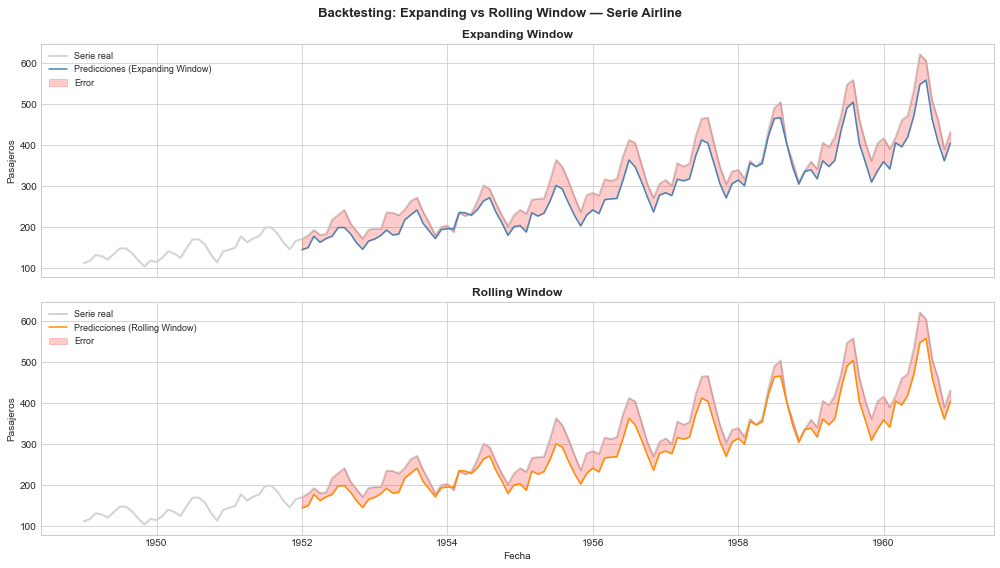

In [19]:
# Comparación visual: predicciones de ambas estrategias
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
fig.suptitle('Backtesting: Expanding vs Rolling Window — Serie Airline', fontsize=13, fontweight='bold')

for ax, pred, titulo, color in [
    (axes[0], pred_exp,  'Expanding Window', 'steelblue'),
    (axes[1], pred_roll, 'Rolling Window',   'darkorange'),
]:
    # Serie completa en gris de fondo
    ax.plot(airline.index, airline['Pasajeros'], color='lightgray', linewidth=2, label='Serie real', zorder=1)
    # Predicciones del backtesting
    ax.plot(pred.index, pred.values, color=color, linewidth=1.5, label=f'Predicciones ({titulo})', zorder=2)
    # Errores (área entre real y pred)
    real_aligned = airline.loc[pred.index, 'Pasajeros']
    ax.fill_between(pred.index, pred.values, real_aligned.values, alpha=0.2, color='red', label='Error')
    ax.set_title(titulo, fontweight='bold')
    ax.legend(loc='upper left', fontsize=9)
    ax.set_ylabel('Pasajeros')

axes[1].set_xlabel('Fecha')
plt.tight_layout()
plt.show()

In [20]:
# Comparación de métricas: Expanding vs Rolling
print("📊 Resultados del Backtesting\n")
m_exp  = calcular_metricas(real_exp.values,  pred_exp.values,  m=12, nombre='Expanding Window')
m_roll = calcular_metricas(real_roll.values, pred_roll.values, m=12, nombre='Rolling Window (window=36)')

tabla_bt = pd.DataFrame({'Expanding': m_exp, 'Rolling': m_roll}).T.round(3)
print("\n📋 Tabla comparativa:")
print(tabla_bt.to_string())

print("""
💬 Discusión:
   • ¿Qué estrategia obtiene mejores métricas en este caso? ¿Por qué?
   • ¿Cambiaría el resultado si la serie tuviese un quiebre estructural (e.g., crisis económica)?
   • ¿Qué pasa si cambiamos el tamaño de la ventana en rolling? Inténtalo con window_size=24 o 48.
""")

📊 Resultados del Backtesting


────────────────────────────────────────
  📊 Expanding Window
────────────────────────────────────────
  MAE   :      34.31
  RMSE  :      38.47
  MAPE  :     10.75%
  sMAPE :     11.49%
  MASE  :     0.0023  ✅ mejor que naive

────────────────────────────────────────
  📊 Rolling Window (window=36)
────────────────────────────────────────
  MAE   :      34.31
  RMSE  :      38.47
  MAPE  :     10.75%
  sMAPE :     11.49%
  MASE  :     0.0023  ✅ mejor que naive

📋 Tabla comparativa:
              MAE    RMSE    MAPE   sMAPE   MASE
Expanding  34.315  38.475  10.746  11.493  0.002
Rolling    34.315  38.475  10.746  11.493  0.002

💬 Discusión:
   • ¿Qué estrategia obtiene mejores métricas en este caso? ¿Por qué?
   • ¿Cambiaría el resultado si la serie tuviese un quiebre estructural (e.g., crisis económica)?
   • ¿Qué pasa si cambiamos el tamaño de la ventana en rolling? Inténtalo con window_size=24 o 48.



### 🔬 Backtesting multi-horizonte

Hasta ahora pronosticamos **1 paso adelante**. En la práctica queremos saber: ¿cómo se degrada el modelo al pronosticar 1, 3, 6, 12 meses?

Esto revela si el modelo es más confiable a corto plazo que a largo plazo.

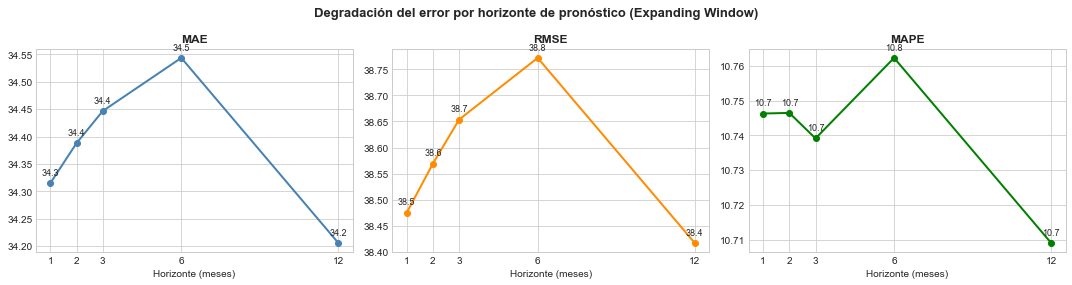


📋 Error por horizonte:
             MAE   RMSE   MAPE
horizonte                     
1          34.31  38.47  10.75
2          34.39  38.57  10.75
3          34.45  38.65  10.74
6          34.54  38.77  10.76
12         34.21  38.42  10.71

💬 Observen: el error generalmente CRECE con el horizonte.
   La tasa de crecimiento nos dice cuánto podemos confiar en el pronóstico a largo plazo.
   Un buen modelo no debería degradarse demasiado rápido.



In [21]:
# Evaluación por horizonte: ¿cómo crece el error con h?
horizontes = [1, 2, 3, 6, 12]
resultados_h = {'horizonte': [], 'MAE': [], 'RMSE': [], 'MAPE': []}

for h in horizontes:
    pred_h, real_h = backtesting_expanding(
        airline['Pasajeros'], init_train=36, horizonte=h, verbose=False
    )
    mae_h  = np.mean(np.abs(real_h.values - pred_h.values))
    rmse_h = np.sqrt(np.mean((real_h.values - pred_h.values) ** 2))
    mape_h = np.mean(np.abs((real_h.values - pred_h.values) / real_h.values)) * 100
    
    resultados_h['horizonte'].append(h)
    resultados_h['MAE'].append(mae_h)
    resultados_h['RMSE'].append(rmse_h)
    resultados_h['MAPE'].append(mape_h)

df_h = pd.DataFrame(resultados_h).set_index('horizonte')

# Visualización
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Degradación del error por horizonte de pronóstico (Expanding Window)', fontsize=13, fontweight='bold')

for ax, col, color in zip(axes, ['MAE', 'RMSE', 'MAPE'], ['steelblue', 'darkorange', 'green']):
    ax.plot(df_h.index, df_h[col], marker='o', linewidth=2, color=color)
    ax.set_title(col, fontweight='bold')
    ax.set_xlabel('Horizonte (meses)')
    ax.set_xticks(horizontes)
    for x, y in zip(df_h.index, df_h[col]):
        ax.annotate(f'{y:.1f}', (x, y), textcoords='offset points', xytext=(0, 8), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\n📋 Error por horizonte:")
print(df_h.round(2).to_string())
print("""
💬 Observen: el error generalmente CRECE con el horizonte.
   La tasa de crecimiento nos dice cuánto podemos confiar en el pronóstico a largo plazo.
   Un buen modelo no debería degradarse demasiado rápido.
""")

### ⚠️ Errores comunes en Backtesting

| Error | Descripción | Consecuencia |
|-------|-------------|-------------|
| **Look-ahead bias** | Usar datos futuros al entrenar o transformar | Métricas artificialmente buenas |
| **Leakage en preprocesamiento** | Normalizar con estadísticas del set completo antes del split | Idem |
| **Ventana inicial muy pequeña** | Poca historia → modelo inestable en primeros folds | Métricas sesgadas |
| **Ignorar el gap** | No dejar espacio entre train y val (útil en datos de alta frecuencia) | Autocorrelación artificial |
| **Evaluar solo 1 horizonte** | Pronóstico a 1 paso no refleja uso real (que suele ser multi-step) | Decisiones erróneas |

#### 🧪 Ejemplo: el peligro del leakage en normalización

In [22]:
# Demostración: leakage al normalizar ANTES del split
from sklearn.preprocessing import StandardScaler

serie_vals = airline['Pasajeros'].values.reshape(-1, 1)
corte = int(len(airline) * 0.8)

# ❌ INCORRECTO: normalizar con toda la serie antes del split
scaler_leak = StandardScaler()
serie_normalizada_leak = scaler_leak.fit_transform(serie_vals)
# La media y std del test ya están 'filtradas' en el scaler → leakage

# ✅ CORRECTO: ajustar el scaler SOLO con train
scaler_ok = StandardScaler()
train_vals = serie_vals[:corte]
test_vals  = serie_vals[corte:]
scaler_ok.fit(train_vals)                                  # solo train
train_norm = scaler_ok.transform(train_vals)               # aplica a train
test_norm  = scaler_ok.transform(test_vals)                # misma escala, SIN refitting

print("❌ Media del scaler con leakage (usa info del futuro):")
print(f"   μ = {scaler_leak.mean_[0]:.2f}  |  σ = {scaler_leak.scale_[0]:.2f}")

print("\n✅ Media del scaler correcto (solo train):")
print(f"   μ = {scaler_ok.mean_[0]:.2f}  |  σ = {scaler_ok.scale_[0]:.2f}")

print("""
📌 La diferencia parece pequeña aquí, pero en series con tendencia fuerte
   el leakage puede inflar el desempeño del modelo significativamente.
   Regla de oro: SIEMPRE fit en train, SOLO transform en test.
""")

❌ Media del scaler con leakage (usa info del futuro):
   μ = 280.30  |  σ = 119.55

✅ Media del scaler correcto (solo train):
   μ = 239.95  |  σ = 90.95

📌 La diferencia parece pequeña aquí, pero en series con tendencia fuerte
   el leakage puede inflar el desempeño del modelo significativamente.
   Regla de oro: SIEMPRE fit en train, SOLO transform en test.



### 📝 - **Expanding window:** más datos de entrenamiento en cada fold → más estable, pero puede incluir historia irrelevante.
- **Rolling window:** ventana fija → más adaptable a cambios recientes, pero pierde historia potencialmente útil.
- **El backtesting multi-horizonte** revela cómo el error crece con el horizonte: información crítica para decisiones de negocio.
- **Leakage en preprocesamiento** es el error más silencioso y frecuente: siempre ajustar transformaciones solo con train.
- En producción, la estrategia de validación debe **imitar** exactamente el proceso de re-entrenamiento real del modelo.

---

---
# Métricas de Evaluación de Pronósticos

---

### ¿Qué tan bueno es mi pronóstico?

Para evaluar necesitamos comparar el **valor pronosticado** $\hat{Y}_t$ con el **valor real** $Y_t$.

El **error de pronóstico** es:

$$e_t = Y_t - \hat{Y}_t$$

---

### Métricas principales


In [23]:
from IPython.display import display, HTML

tabla_html = """
<style>
  .metrics-table { border-collapse: collapse; width: 100%; font-size: 14px; font-family: Arial, sans-serif; }
  .metrics-table th { background: #2E75B6; color: white; padding: 10px 14px; text-align: left; }
  .metrics-table td { padding: 9px 14px; border-bottom: 1px solid #D0E4F7; vertical-align: middle; }
  .metrics-table tr:nth-child(odd)  { background: #EBF3FB; }
  .metrics-table tr:nth-child(even) { background: #FFFFFF; }
  .metrics-table tr:hover { background: #D6EAF8; }
  .formula { font-family: 'Times New Roman', serif; font-size: 15px; }
  .tag-green { color: #1E8449; font-weight: bold; }
  .tag-red   { color: #C0392B; font-weight: bold; }
</style>

<table class='metrics-table'>
  <thead>
    <tr>
      <th>Métrica</th>
      <th>Fórmula</th>
      <th style='text-align:center'>Unidades</th>
      <th style='text-align:center'>Outliers</th>
      <th>Cuándo usarla</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><strong>MAE</strong><br><small>Mean Absolute Error</small></td>
      <td class='formula'>\u00bd &middot; &sum; |e&#8321;| ... &nbsp;
        <span style='font-size:13px; color:#555'>(ver fórmula abajo)</span>
      </td>
      <td style='text-align:center'>Igual que Y</td>
      <td style='text-align:center'><span class='tag-green'>&#10004; No</span></td>
      <td>Interpretación directa. Error promedio en la escala original.</td>
    </tr>
  </tbody>
</table>
"""

# La tabla HTML sola no renderiza LaTeX.
# Usamos display(HTML) para el layout y display separados para las fórmulas.

tabla_display = HTML("""
<style>
  .mt { border-collapse:collapse; width:100%; font-size:14px; }
  .mt th { background:#2E75B6; color:#fff; padding:9px 13px; text-align:left; }
  .mt td { padding:9px 13px; border-bottom:1px solid #cde; vertical-align:top; }
  .mt tr:nth-child(odd)  { background:#EBF3FB; }
  .mt tr:nth-child(even) { background:#fff; }
  .ok  { color:#1a7a3c; font-weight:bold; }
  .bad { color:#b03030; font-weight:bold; }
  .fn  { font-size:15px; }
</style>

<table class='mt'>
<thead><tr>
  <th style='width:10%'>Métrica</th>
  <th style='width:30%'>Fórmula</th>
  <th style='width:13%;text-align:center'>Unidades</th>
  <th style='width:13%;text-align:center'>Outliers</th>
  <th>Cuándo usarla</th>
</tr></thead>
<tbody>

<tr>
  <td><b>MAE</b></td>
  <td class='fn'>(1/n) &sdot; &sum; |e&#8321;| </td>
  <td style='text-align:center'>Igual que Y</td>
  <td style='text-align:center'><span class='ok'>&#10004; No</span></td>
  <td>Interpretación directa en la escala de la serie</td>
</tr>

<tr>
  <td><b>RMSE</b></td>
  <td class='fn'>&radic;[ (1/n) &sdot; &sum; e&#8321;&sup2; ]</td>
  <td style='text-align:center'>Igual que Y</td>
  <td style='text-align:center'><span class='bad'>&#10008; S&iacute;</span></td>
  <td>Cuando los errores grandes deben penalizarse más</td>
</tr>

<tr>
  <td><b>MAPE</b></td>
  <td class='fn'>(1/n) &sdot; &sum; |e&#8321; / Y&#8321;| &sdot; 100</td>
  <td style='text-align:center'>%</td>
  <td style='text-align:center'><span class='ok'>&#10004; No</span></td>
  <td>Comunicar a negocio &mdash; &#9888;&#65039; falla si Y&#8321; = 0</td>
</tr>

<tr>
  <td><b>sMAPE</b></td>
  <td class='fn'>(200/n) &sdot; &sum; |e&#8321;| / (|Y&#8321;| + |&#374;&#8321;|)</td>
  <td style='text-align:center'>%</td>
  <td style='text-align:center'><span class='ok'>&#10004; No</span></td>
  <td>Alternativa sim&eacute;trica al MAPE</td>
</tr>

<tr>
  <td><b>MASE</b></td>
  <td class='fn'>MAE / MAE<sub>naive</sub></td>
  <td style='text-align:center'>Sin unidades</td>
  <td style='text-align:center'><span class='ok'>&#10004; No</span></td>
  <td>Comparar series de distinta escala &mdash; &lt;1 = mejor que naive</td>
</tr>

</tbody>
</table>
""")

display(tabla_display)

Métrica,Fórmula,Unidades,Outliers,Cuándo usarla
MAE,(1/n) ⋅ ∑ |e₁|,Igual que Y,✔ No,Interpretación directa en la escala de la serie
RMSE,√[ (1/n) ⋅ ∑ e₁² ],Igual que Y,✘ Sí,Cuando los errores grandes deben penalizarse más
MAPE,(1/n) ⋅ ∑ |e₁ / Y₁| ⋅ 100,%,✔ No,Comunicar a negocio — ⚠️ falla si Y₁ = 0
sMAPE,(200/n) ⋅ ∑ |e₁| / (|Y₁| + |Ŷ₁|),%,✔ No,Alternativa simétrica al MAPE
MASE,MAE / MAEnaive,Sin unidades,✔ No,Comparar series de distinta escala — <1 = mejor que naive


#### Fórmulas detalladas

$$\text{MAE} = \frac{1}{n}\sum_{t=1}^{n}\left| e_t \right|$$

$$\text{RMSE} = \sqrt{\frac{1}{n}\sum_{t=1}^{n} e_t^2}$$

$$\text{MAPE} = \frac{1}{n}\sum_{t=1}^{n}\left|\frac{e_t}{Y_t}\right| \times 100$$

$$\text{sMAPE} = \frac{200}{n}\sum_{t=1}^{n}\frac{\left|e_t\right|}{\left|Y_t\right| + \left|\hat{Y}_t\right|}$$

$$\text{MASE} = \frac{\text{MAE}}{\frac{1}{n-m}\sum_{t=m+1}^{n}\left|Y_t - Y_{t-m}\right|}$$

> **Benchmarks naive:**  
> $\hat{Y}_{t+1} = Y_t$ — *naive simple (último valor)*  
> $\hat{Y}_{t+1} = Y_{t-m}$ — *naive estacional ($m$ = período)*


In [24]:
# ── Función movida al bloque de utilidades (celda 4) ──
print('✅ calcular_metricas disponible desde el bloque de setup')

✅ calcular_metricas disponible desde el bloque de setup


In [25]:
# Generamos pronósticos de benchmark para comparar

# Benchmark 1: Naive (Y_{t+1} = Y_t)
pred_naive     = train['Pasajeros'].iloc[-1] * np.ones(len(test))

# Benchmark 2: Naive estacional (Y_{t+1} = Y_{t-12})
pred_naive_s   = train['Pasajeros'].iloc[-12:].values  # últimos 12 meses
# repetir si test > 12
reps = int(np.ceil(len(test) / 12))
pred_naive_s   = np.tile(pred_naive_s, reps)[:len(test)]

# Benchmark 3: Media histórica
pred_media     = train['Pasajeros'].mean() * np.ones(len(test))

# Benchmark 4: Tendencia lineal simple
from numpy.polynomial import polynomial as P
x_train = np.arange(len(train))
coef = np.polyfit(x_train, train['Pasajeros'].values, 1)
x_test = np.arange(len(train), len(train) + len(test))
pred_lineal = np.polyval(coef, x_test)

# Comparar métricas
y_real = test['Pasajeros'].values
metricas_naive   = calcular_metricas(y_real, pred_naive,   m=12, nombre='Naive (último valor)')
metricas_naive_s = calcular_metricas(y_real, pred_naive_s, m=12, nombre='Naive Estacional (lag-12)')
metricas_media   = calcular_metricas(y_real, pred_media,   m=12, nombre='Media histórica')
metricas_lineal  = calcular_metricas(y_real, pred_lineal,  m=12, nombre='Tendencia lineal')


────────────────────────────────────────
  📊 Naive (último valor)
────────────────────────────────────────
  MAE   :      81.45
  RMSE  :      93.13
  MAPE  :     20.20%
  sMAPE :     18.06%
  MASE  :     0.0044  ✅ mejor que naive

────────────────────────────────────────
  📊 Naive Estacional (lag-12)
────────────────────────────────────────
  MAE   :      64.76
  RMSE  :      75.23
  MAPE  :     14.04%
  sMAPE :     15.43%
  MASE  :     0.0035  ✅ mejor que naive

────────────────────────────────────────
  📊 Media histórica
────────────────────────────────────────
  MAE   :     200.36
  RMSE  :     215.06
  MAPE  :     43.85%
  sMAPE :     57.12%
  MASE  :     0.0109  ✅ mejor que naive

────────────────────────────────────────
  📊 Tendencia lineal
────────────────────────────────────────
  MAE   :      55.99
  RMSE  :      73.80
  MAPE  :     12.07%
  sMAPE :     12.53%
  MASE  :     0.0030  ✅ mejor que naive


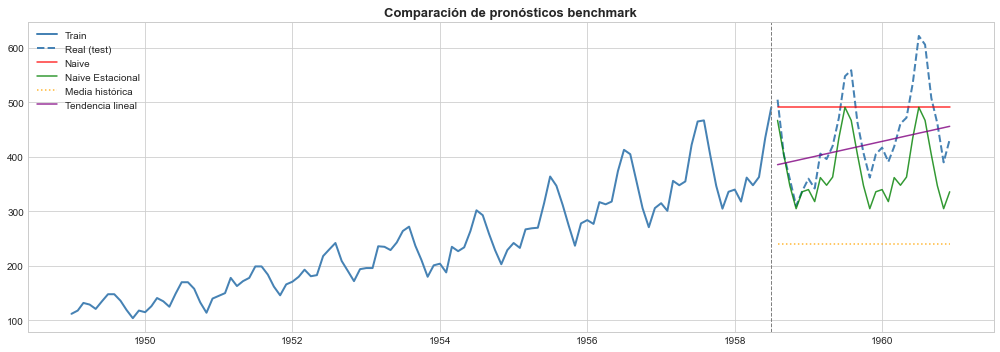

In [26]:
# Visualización de los pronósticos
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(train.index, train['Pasajeros'], color='steelblue', linewidth=2, label='Train')
ax.plot(test.index,  test['Pasajeros'],  color='steelblue', linewidth=2, linestyle='--', label='Real (test)')

ax.plot(test.index, pred_naive,   color='red',    linewidth=1.5, label='Naive',               alpha=0.8)
ax.plot(test.index, pred_naive_s, color='green',  linewidth=1.5, label='Naive Estacional',     alpha=0.8)
ax.plot(test.index, pred_media,   color='orange', linewidth=1.5, label='Media histórica',      alpha=0.8, linestyle=':')
ax.plot(test.index, pred_lineal,  color='purple', linewidth=1.5, label='Tendencia lineal',     alpha=0.8)

ax.axvline(x=train.index[-1], color='gray', linestyle='--', linewidth=1)
ax.set_title('Comparación de pronósticos benchmark', fontsize=13, fontweight='bold')
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [27]:
# Tabla comparativa de métricas
tabla = pd.DataFrame({
    'Naive':             metricas_naive,
    'Naive Estacional':  metricas_naive_s,
    'Media':             metricas_media,
    'Lineal':            metricas_lineal,
}).T.round(2)

print("\n📊 Tabla comparativa de métricas:")
print(tabla.to_string())

print("""
💬 Discusión:
   • ¿Qué modelo gana en MAPE? ¿Y en MASE?
   • ¿Cuál tiene MASE < 1? → ese es mejor que el naive
   • ¿Hay diferencia entre MAE y RMSE grande? → indica outliers
""")


📊 Tabla comparativa de métricas:
                     MAE    RMSE   MAPE  sMAPE  MASE
Naive              81.45   93.13  20.20  18.06  0.00
Naive Estacional   64.76   75.23  14.04  15.43  0.00
Media             200.36  215.06  43.85  57.12  0.01
Lineal             55.99   73.80  12.07  12.53  0.00

💬 Discusión:
   • ¿Qué modelo gana en MAPE? ¿Y en MASE?
   • ¿Cuál tiene MASE < 1? → ese es mejor que el naive
   • ¿Hay diferencia entre MAE y RMSE grande? → indica outliers



### ⚠️ Limitaciones del MAPE

El MAPE tiene problemas conocidos:

In [28]:
# Problema 1: MAPE indefinido cuando Y_real = 0
y_r = np.array([100, 0, 50, 200])
y_p = np.array([90,  5, 55, 180])
print("Valores reales:       ", y_r)
print("Pronósticos:          ", y_p)
print("Error / Y_real:       ", np.where(y_r != 0, np.abs(y_r - y_p) / y_r, 'inf'))
print("→ Con Y_real=0, MAPE da infinito o NaN\n")

# Problema 2: MAPE es asimétrico (penaliza más sobreestimación)
y_r = np.array([100])
y_bajo = np.array([50])  # subestimamos un 50%
y_alto = np.array([200]) # sobreestimamos un 100%

mape_bajo = abs(y_r - y_bajo) / y_r * 100
mape_alto = abs(y_r - y_alto) / y_r * 100
print(f"Y_real=100, Y_pred=50  (subestimación 50%):  MAPE = {mape_bajo[0]:.1f}%")
print(f"Y_real=100, Y_pred=200 (sobreestimación 100%): MAPE = {mape_alto[0]:.1f}%")
print("→ Un error 'igual' en magnitud produce MAPE diferente")
print("→ sMAPE o MASE son alternativas más robustas")

Valores reales:        [100   0  50 200]
Pronósticos:           [ 90   5  55 180]
Error / Y_real:        ['0.1' 'inf' '0.1' '0.1']
→ Con Y_real=0, MAPE da infinito o NaN

Y_real=100, Y_pred=50  (subestimación 50%):  MAPE = 50.0%
Y_real=100, Y_pred=200 (sobreestimación 100%): MAPE = 100.0%
→ Un error 'igual' en magnitud produce MAPE diferente
→ sMAPE o MASE son alternativas más robustas


### 📌 Guía de selección de métricas

| Situación | Métrica recomendada |
|-----------|--------------------|
| Comparar en mismas unidades | MAE o RMSE |
| Outliers importan mucho | RMSE |
| Comparar series con diferente escala | MAPE o sMAPE |
| Valores cercanos a cero posibles | sMAPE o MASE |
| Comparar contra un benchmark naive | MASE |
| Comunicar a negocio | MAPE (% intuitivo) |

---
# Diagnóstico de Residuos

---

### ¿Por qué analizar los residuos?

Un modelo bien ajustado debe dejar residuos que sean **ruido blanco**:

| Propiedad | Qué verificar |
|-----------|---------------|
| Media cero | Los errores no deben tener sesgo sistemático |
| Sin autocorrelación | El modelo capturó toda la estructura temporal |
| Varianza constante | No heterocedasticidad |
| Normalidad (opcional) | Para intervalos de confianza correctos |

Si los residuos tienen estructura → **el modelo puede mejorar**.

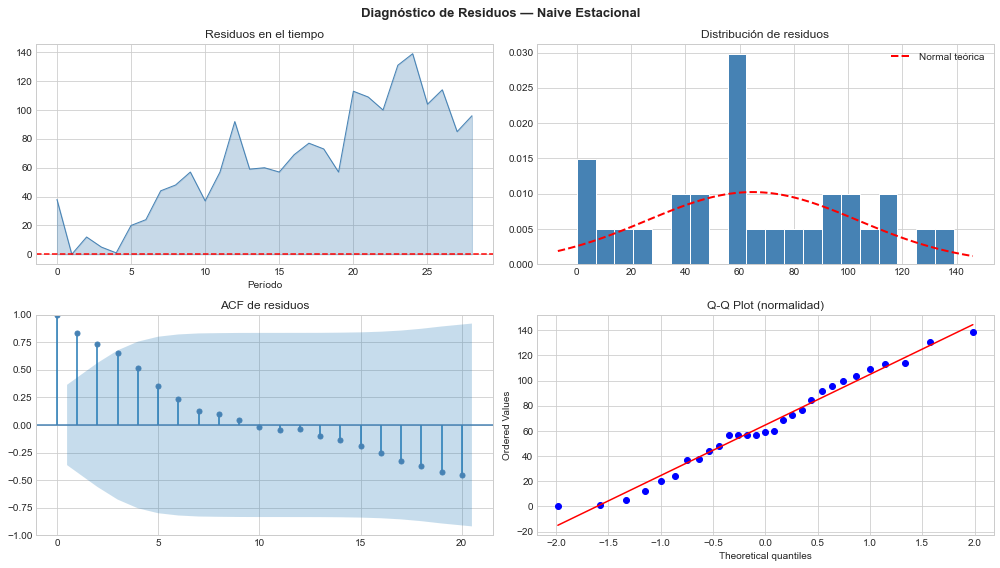


📋 Resumen estadístico de residuos (Naive Estacional):
   Media:                64.7586  ⚠️
   Desv. estándar:       38.9722
   Skewness:              0.0512  ✅
   Kurtosis:             -0.7958  ✅

   Ljung-Box (lags 1-20):  ⚠️ Autocorrelación detectada
   Shapiro-Wilk:      p=0.5690  ✅ Normalidad OK


In [29]:
 # Aplicamos el diagnóstico  a los residuos del naive estacional
residuos_naive_s = test['Pasajeros'].values - pred_naive_s
diagnostico_residuos(residuos_naive_s, 'Naive Estacional')

---
# Ejercicio

---

Trabajaremos con el dataset **retail** (ventas semanales) y aplicaremos todo el flujo de evaluación.

### Instrucciones:
1. Visualiza la serie y describe sus componentes.
2. Aplica las pruebas ADF y KPSS. ¿Es estacionaria?
3. Aplica la transformación necesaria para lograr estacionariedad.
4. Grafica ACF y PACF de la serie transformada.
5. Realiza el train/test split (80/20).
6. Genera pronósticos naive y naive estacional.
7. Calcula y compara las métricas.
8. Diagnostica los residuos del mejor modelo.

---

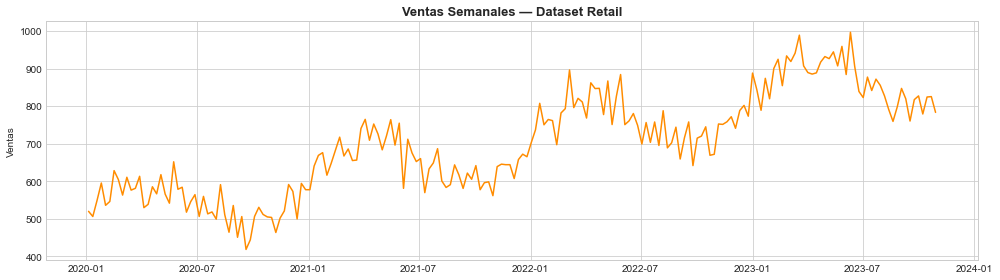


🔍 Estadísticas descriptivas:
count    200.00
mean     699.96
std      131.18
min      418.31
25%      590.94
50%      696.87
75%      794.09
max      996.97
Name: Ventas, dtype: float64


In [30]:
# Paso 1: Visualización
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(retail.index, retail['Ventas'], color='darkorange', linewidth=1.5)
ax.set_title('Ventas Semanales — Dataset Retail', fontsize=13, fontweight='bold')
ax.set_ylabel('Ventas')
plt.tight_layout()
plt.show()

print("\n🔍 Estadísticas descriptivas:")
print(retail['Ventas'].describe().round(2))

In [31]:
# Paso 2: Pruebas de estacionariedad
test_estacionariedad(retail['Ventas'], 'Retail — Original')

  Pruebas de Estacionariedad: Retail — Original

📌 Test ADF
   Estadístico: -1.6082
   p-value:     0.4795
   Lags usados: 9
   Resultado:   ❌ No estacionaria (H₀ rechazada = estacionaria)

📌 Test KPSS
   Estadístico: 1.6555
   p-value:     0.0100  (aprox.)
   Lags usados: 9
   Resultado:   ❌ No estacionaria (H₀ no rechazada = estacionaria)



In [32]:
# Paso 3: Transformación  
retail_diff = retail['Ventas'].diff().dropna()
test_estacionariedad(retail_diff, 'Retail — Primera diferencia')

  Pruebas de Estacionariedad: Retail — Primera diferencia

📌 Test ADF
   Estadístico: -3.5389
   p-value:     0.0070
   Lags usados: 8
   Resultado:   ✅ Estacionaria (H₀ rechazada = estacionaria)

📌 Test KPSS
   Estadístico: 0.0614
   p-value:     0.1000  (aprox.)
   Lags usados: 10
   Resultado:   ✅ Estacionaria (H₀ no rechazada = estacionaria)



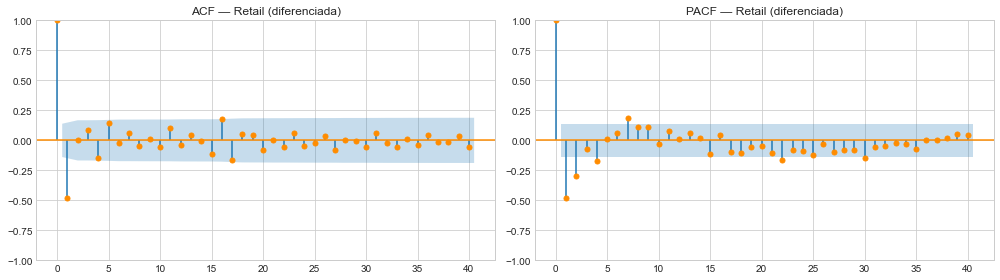

In [33]:
# Paso 4: ACF y PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(retail_diff,  lags=40, ax=axes[0], title='ACF — Retail (diferenciada)',  color='darkorange')
plot_pacf(retail_diff, lags=40, ax=axes[1], title='PACF — Retail (diferenciada)', color='darkorange')
plt.tight_layout()
plt.show()


────────────────────────────────────────
  📊 Naive
────────────────────────────────────────
  MAE   :      51.64
  RMSE  :      60.54
  MAPE  :      6.00%
  sMAPE :      5.94%
  MASE  :        nan  

────────────────────────────────────────
  📊 Naive Estacional (lag-52)
────────────────────────────────────────
  MAE   :     109.29
  RMSE  :     122.18
  MAPE  :     12.44%
  sMAPE :     13.48%
  MASE  :        nan  

────────────────────────────────────────
  📊 Media Móvil 4 semanas
────────────────────────────────────────
  MAE   :      53.42
  RMSE  :      63.96
  MAPE  :      6.04%
  sMAPE :      6.15%
  MASE  :        nan  


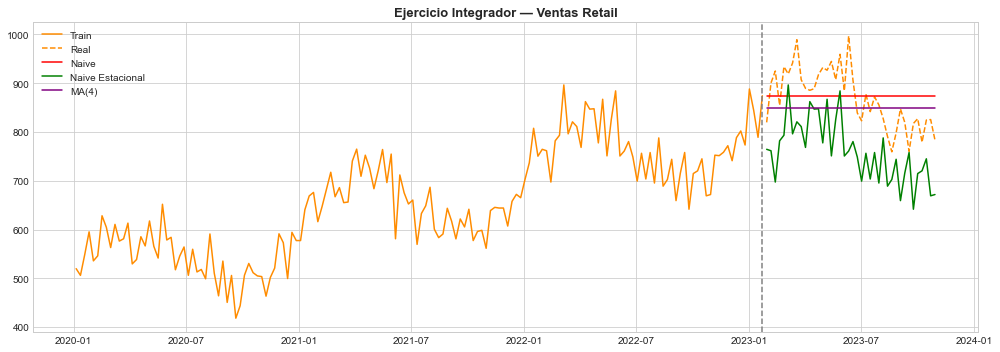

In [34]:
# Pasos 5-8: Split, pronósticos, métricas y diagnóstico
n_train_r = int(len(retail) * 0.8)
train_r = retail.iloc[:n_train_r]
test_r  = retail.iloc[n_train_r:]

# Pronósticos
naive_r    = np.full(len(test_r), train_r['Ventas'].iloc[-1])

# Naive estacional semanal (lag=52)
lag_s = 52
if len(train_r) >= lag_s:
    base_s = train_r['Ventas'].iloc[-lag_s:].values
    reps_r = int(np.ceil(len(test_r) / lag_s))
    naive_s_r = np.tile(base_s, reps_r)[:len(test_r)]
else:
    naive_s_r = naive_r.copy()

# Media móvil simple de las últimas 4 semanas
ma4 = np.full(len(test_r), train_r['Ventas'].iloc[-4:].mean())

y_r_r = test_r['Ventas'].values
m_naive   = calcular_metricas(y_r_r, naive_r,   m=52, nombre='Naive')
m_naive_s = calcular_metricas(y_r_r, naive_s_r, m=52, nombre='Naive Estacional (lag-52)')
m_ma4     = calcular_metricas(y_r_r, ma4,        m=52, nombre='Media Móvil 4 semanas')

# Visualización
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(train_r.index, train_r['Ventas'], color='darkorange', linewidth=1.5, label='Train')
ax.plot(test_r.index,  test_r['Ventas'],  color='darkorange', linewidth=1.5, linestyle='--', label='Real')
ax.plot(test_r.index, naive_r,   color='red',    linewidth=1.5, label='Naive')
ax.plot(test_r.index, naive_s_r, color='green',  linewidth=1.5, label='Naive Estacional')
ax.plot(test_r.index, ma4,       color='purple', linewidth=1.5, label='MA(4)')
ax.axvline(x=train_r.index[-1], color='gray', linestyle='--')
ax.set_title('Ejercicio Integrador — Ventas Retail', fontsize=13, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

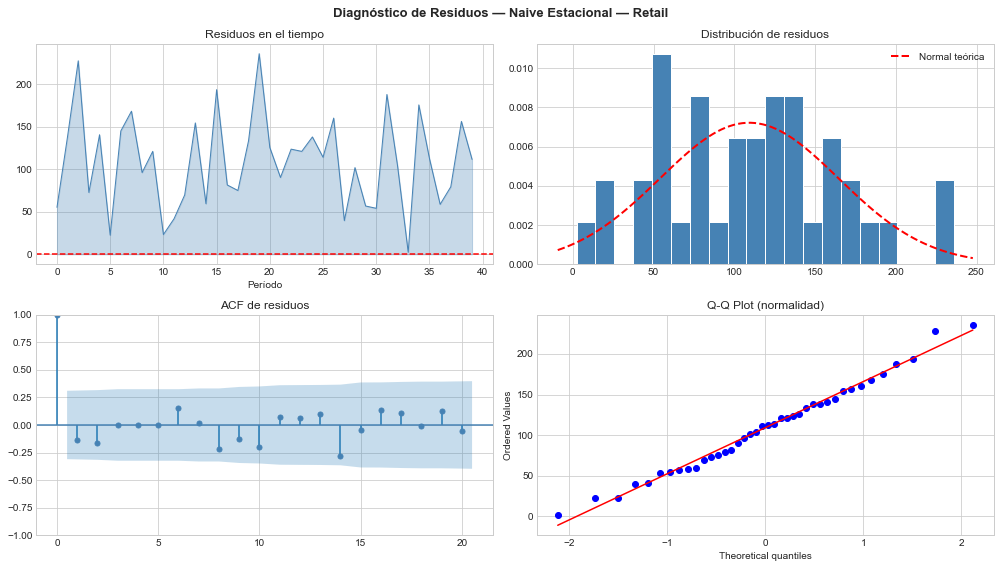


📋 Resumen estadístico de residuos (Naive Estacional — Retail):
   Media:               109.2905  ⚠️
   Desv. estándar:       55.3200
   Skewness:              0.2663  ✅
   Kurtosis:             -0.2868  ✅

   Ljung-Box (lags 1-20):  ✅ Sin autocorrelación significativa
   Shapiro-Wilk:      p=0.8815  ✅ Normalidad OK


In [35]:
# Diagnóstico del mejor modelo
mejor_pred = naive_s_r  # generalmente el naive estacional gana en series con estacionalidad
residuos_ej = y_r_r - mejor_pred
diagnostico_residuos(residuos_ej, 'Naive Estacional — Retail')

---

### 🔮 Próxima sesión: Modelos de Suavización Exponencial (ETS)

- Simple Exponential Smoothing
- Holt (con tendencia)
- Holt-Winters (con tendencia y estacionalidad)
- Selección de parámetros con `statsmodels`

---

### 📚 Referencias recomendadas

- Hyndman, R.J. & Athanasopoulos, G. (2021). *Forecasting: Principles and Practice* (3a ed.). **Gratuito online:** https://otexts.com/fpp3/
- Statsmodels documentation: https://www.statsmodels.org/stable/tsa.html
- Sklearn TimeSeriesSplit: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html